# Projet Immothep

Dans un premier temps nous avons décidé de nous concentrer seulement sur la ville de Bordeaux car c'est une grande ville française ne possèdant pas d'arrondissements.

Du fait que cela soit simplement une ville et non pas la France entière nous pouvons observer plus simplement si la précision de notre algorithme est faussée par des données de notre jeu de données.

Pour nettoyer notre jeu de données nous avons tout d'abord enlevé l'ensemble des colonnes non nécessaires à nos requêtes afin de ne conserver que les colonnes utiles (La nature de la mutation, la valeur fonciere, le code postal, le type de local, le nombre de pièces principales, la surface du terrain et la surface réelle bati)

Concernant le type de local nous ne souhaitons estimer que les biens étant des appartements ou des maisons. Pour la nature de la mutation nous ne conservons que les biens ayant été mis en vente.

Nous n'avons pas conservé les surfaces loi Carrez ainsi que les nombres de lots car cela faussait le jeu de données (Trop grande présence de lignes vides).

En effet nous avons remarqué dans la documentation fournie par le site data.gouv.fr (D'où provient notre jeu de données) que la note descriptive de ce fichier nous indiquait que seuls les 5 premiers lots d'un lot plus important étaient restitués au sein du document.

Le minimum légal en France pour la superficie d'un logement étant de 9m² nous avons donc décidé de supprimer de notre jeu de données tous les biens immobiliers ayant une surface réelle bati inférieure à 9m².

Nous avons aussi enlevé de notre jeu de données les biens ayant 0 pièce principale car cela est illogique (Le minimum d'un bien étant une pièce principale).

## Import des librairies

In [1]:
# IPython extension reloading modules before user enters code.
%load_ext autoreload
%autoreload 2

from functions import download
from functions import isolation_forest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline

## Téléchargement du dataset

In [2]:
downloader_object = download.Downloader('./data')

downloader_object.data_download('valeursfoncieres-2019.txt', 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2')

Data downloading...
Download finished


In [3]:
df0 = pd.read_csv('./data/RAW/valeursfoncieres-2019.txt', decimal = ',', sep = '|')
df0.columns.tolist()
df0 = df0.drop(columns = ['Code service CH',
 'Reference document',
 '1 Articles CGI',
 '2 Articles CGI',
 '3 Articles CGI',
 '4 Articles CGI',
 '5 Articles CGI',
 'No disposition',
 'Date mutation',
 'No voie',
 'B/T/Q',
 'Type de voie',
 'Code voie',
 'Voie',
 'Code departement',
 'Code commune',
 'Prefixe de section',
 'Section',
 'No plan',
 'No Volume',
 '1er lot',
 'Surface Carrez du 1er lot',
 '2eme lot',
 'Surface Carrez du 2eme lot',
 '3eme lot',
 'Surface Carrez du 3eme lot',
 '4eme lot',
 'Surface Carrez du 4eme lot',
 '5eme lot',
 'Surface Carrez du 5eme lot',
 'Nombre de lots',
 'Code type local',
 'Identifiant local',
 'Nature culture',
 'Nature culture speciale'])
df = df0.copy() 

## Fonction preprocessing

Cette fonction nous permet d'appliquer directement nos filtres à notre DataFrame.

In [4]:
def preprocessing(df):
    df = df.drop_duplicates()
    df = df.dropna(subset = ['Type local'])
    df = df[df['Type local'].isin(['Maison','Appartement'])]
    df = df[df['Commune'].isin(['BORDEAUX'])]
    df = df[df['Nature mutation'].isin(['Vente'])]
    df = df.dropna(subset = ['Code postal', 'Valeur fonciere'])
    df = df[df["Surface reelle bati"] > 8]
    df = df[df["Nombre pieces principales"] >= 1]
    df = df.fillna(0)

    return df

In [5]:
df = preprocessing(df)
df = df.drop(columns = ['Nature mutation', 'Commune', 'Type local'])
df = df.to_csv('./data/CURATED/csv_clean_bordeaux.csv')

## Utilisation de l'Isolation Forest

Cet algorithme nous permet d'enlever toutes les valeurs aberrantes au sein de notre jeu de données. Elles sont notifiées en tant qu'anomalie.

In [6]:
isolation_forest.isolation_forest('./data/CURATED/csv_clean_bordeaux.csv', './data/CURATED/anomaly_csv_clean_bordeaux.csv')

df_bordeaux = pd.read_csv('./data/CURATED/csv_clean_bordeaux.csv', sep = ',', usecols = ['Unnamed: 0', 'Valeur fonciere', 'Code postal', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain'])
df_bordeaux_anomaly = pd.read_csv('./data/CURATED/anomaly_csv_clean_bordeaux.csv', sep = ',')
df_bordeaux_anomaly = df_bordeaux_anomaly.drop(columns = ['Unnamed: 0', 'Valeur fonciere', 'Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'scores'])
df_bordeaux_anomaly = df_bordeaux_anomaly.rename(columns = {'Unnamed: 0.1':'Unnamed: 0'})
df_bordeaux = df_bordeaux.merge(df_bordeaux_anomaly, how = 'left', on = 'Unnamed: 0')
df_bordeaux = df_bordeaux.fillna(0)
df_bordeaux = df_bordeaux[df_bordeaux["anomaly"] == 0]
df_bordeaux = df_bordeaux.drop(columns = ['Unnamed: 0', 'anomaly'])
df_bordeaux['Valeur fonciere']  = df_bordeaux['Valeur fonciere'].astype(int)
df_bordeaux['Code postal']  = df_bordeaux['Code postal'].astype(int)
df_bordeaux['Surface reelle bati']  = df_bordeaux['Surface reelle bati'].astype(int)
df_bordeaux['Nombre pieces principales']  = df_bordeaux['Nombre pieces principales'].astype(int)
df_bordeaux['Surface terrain']  = df_bordeaux['Surface terrain'].astype(int)

   Unnamed: 0  Valeur fonciere  Code postal  Surface reelle bati  \
0      673559          80000.0      33000.0                 16.0   
1      673577         421000.0      33300.0                136.0   
2      673579         210000.0      33000.0                 63.0   
3      673581         447850.0      33300.0                 77.0   
4      673582         613000.0      33200.0                 90.0   
5      673590         116000.0      33000.0                 25.0   
6      673600         320000.0      33000.0                 80.0   
7      673606         190000.0      33300.0                 52.0   
8      673609         280000.0      33300.0                 73.0   
9      673618         316500.0      33200.0                 84.0   

   Nombre pieces principales  Surface terrain    scores  anomaly  
0                        1.0              0.0  0.012621        1  
1                        6.0            337.0 -0.057158       -1  
2                        3.0              0.0  0.0

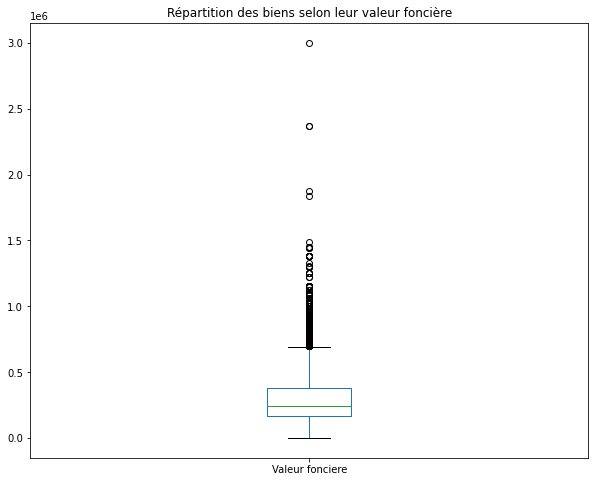

In [7]:
df_bordeaux['Valeur fonciere'].plot(kind = 'box', title = 'Répartition des biens selon leur valeur foncière', figsize = (10, 8))
plt.show()

## Utilisation des quantiles

Nous avons décidé d'enlever les 10% les plus hauts et les plus bas de notre colonne 'Valeur fonciere' afin d'enlever les dernières valeurs disparates de notre jeu de données.

In [8]:
df_bordeaux = df_bordeaux[df_bordeaux['Valeur fonciere'].between(df_bordeaux['Valeur fonciere'].quantile(.10), df_bordeaux['Valeur fonciere'].quantile(.90))]

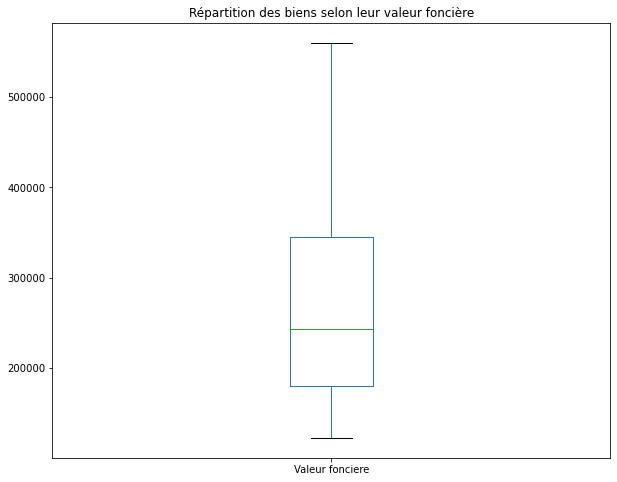

In [9]:
df_bordeaux['Valeur fonciere'].plot(kind = 'box', title = 'Répartition des biens selon leur valeur foncière', figsize = (10, 8))
plt.show()

Nous pouvons observer dans le boxplot ci-dessus que les valeurs éloignées ont été supprimé par l'utilisation des quantiles.

## Calcul du Prix moyen au m² pour chaque code postal

Nous pensons que le prix moyen au m² est plus intéressant pour évaluer la valeur d'un bien immobilier.

In [10]:
df_bordeaux = df_bordeaux.to_csv('./data/CURATED/csv_clean_bordeaux_2.csv')

In [11]:
df_clean = pd.read_csv('./data/CURATED/csv_clean_bordeaux_2.csv', usecols=['Valeur fonciere', 'Code postal', 'Surface reelle bati', 'Surface terrain'])
df_clean['Prix moyen m²'] = df_clean['Valeur fonciere']/df_clean['Surface reelle bati']
df_prix_moyen = df_clean.groupby('Code postal').mean('Prix moyen m²').drop(columns = ['Valeur fonciere', 'Surface reelle bati'])
dict_prix_moyen = df_prix_moyen.to_dict()
df_clean = df_clean.drop(columns = 'Prix moyen m²')
df_prix_moyen = df_prix_moyen.drop(columns = 'Surface terrain')
df_clean = df_clean.merge(df_prix_moyen, how = 'left', on = 'Code postal')
df_clean = df_clean.drop(columns = 'Code postal')
df_clean = df_clean.to_csv('./data/CURATED/csv_clean_bordeaux_final.csv')

## Utilisation de Random Forest Regressor

Nous avons utiliser cet algorithme car il est simple à mettre en place ainsi que précis. De plus il correspondait à nos besoins en combinant régression et classification. En effet cet algorithme obtient des bons scores lorsqu'il s'agit de faire de la prédiction.

In [12]:
features = pd.read_csv("./data/CURATED/csv_clean_bordeaux_final.csv", usecols = ['Valeur fonciere', 'Surface reelle bati', 'Surface terrain', 'Prix moyen m²'])

<AxesSubplot:>

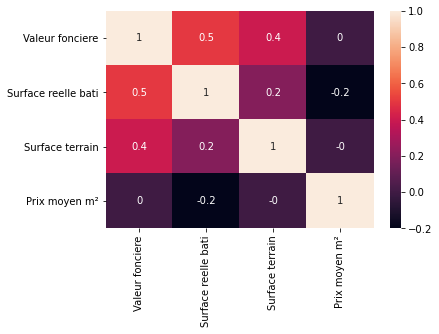

In [13]:
matrice_correlation = features.corr().round(1)
sns.heatmap(data = matrice_correlation, annot = True)

In [14]:
# Labels are the values we want to predict
labels = np.array(features['Valeur fonciere'])
# Remove the labels from the features
features = features.drop('Valeur fonciere', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns) 
# Convert to numpy array
features = np.array(features)
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 1)

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2865, 3)
Training Labels Shape: (2865,)
Testing Features Shape: (955, 3)
Testing Labels Shape: (955,)


In [16]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=50, random_state=1)

In [17]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'euros.')

Mean Absolute Error: 61712.63 euros.


In [18]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.55 %.


In [24]:
r2 = metrics.r2_score(test_labels, predictions)
print(f"R² = {r2}")

R² = 0.4461373825062661
